In [1]:
import geopandas as gpd
import pandas as pd
#import geoplot as gplt
import laspy
import shapely
import os
from datetime import datetime
import numpy as np
from itertools import product
import math
import pyproj
import re
import pyspark

In [32]:
resolution = 10  #grid resolution in meters
outPath = f"{os.curdir}{os.sep}output{os.sep}"
outputFileName = f"{outPath}AggregateLidarData_SomeHoods_{resolution}m.pickle"
captureHoods = ['GENTILLY TERRACE','GENTILLY WOODS','MARIGNY','BYWATER','ST. CLAUDE','PONTCHARTRAIN PARK','DESIRE AREA',\
               'FRENCH QUARTER','ST. BERNARD AREA', 'ST. CLAUDE', 'ST. ROCH']

In [3]:
if not os.path.exists(outPath):
    lp(f"Creating output path {outPath}")
    os.makedirs(outPath)

In [4]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-03-25 21:23:20.509101] Starting...


In [5]:
lp("Creating spark context")
conf = pyspark.SparkConf().setAppName("ProcessLidar").setMaster("spark://127.0.0.1:7077")
sc = pyspark.SparkContext(conf=conf)

[2025-03-25 21:23:20.513067] Creating spark context


25/03/25 22:23:21 WARN Utils: Your hostname, G-ChaosStation resolves to a loopback address: 127.0.1.1; using 192.168.12.163 instead (on interface eno1)
25/03/25 22:23:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/25 22:23:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
fullDataPath = os.path.realpath(dataPath) + os.sep
lp(f"Path:  {dataPath}\t\tFullPath:{fullDataPath}")

[2025-03-25 21:23:23.287566] Path:  ./datasets/		FullPath:/home/g/Dev/NewOrleansElevation/datasets/


In [7]:
testLasFileName = os.listdir(f"{dataPath}laz")[5]
lp(f"Opening {testLasFileName} to get crs and more")
testLas = laspy.read(f"{dataPath}laz{os.sep}{testLasFileName}")

[2025-03-25 21:23:23.307240] Opening USGS_LPC_LA_2021GreaterNewOrleans_C22_w0819n3342.laz to get crs and more


In [8]:
neighborhoodDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").to_crs(testLas.vlrs[0].parse_crs())

In [9]:
sorted(neighborhoodDf['gnocdc_lab'].unique())

['ALGIERS POINT',
 'AUDUBON',
 'B. W. COOPER',
 'BAYOU ST. JOHN',
 'BEHRMAN',
 'BLACK PEARL',
 'BROADMOOR',
 'BYWATER',
 'CENTRAL BUSINESS DISTRICT',
 'CENTRAL CITY',
 'CITY PARK',
 'DESIRE AREA',
 'DILLARD',
 'DIXON',
 'EAST CARROLLTON',
 'EAST RIVERSIDE',
 'FAIRGROUNDS',
 'FILMORE',
 'FISCHER DEV',
 'FLORIDA AREA',
 'FLORIDA DEV',
 'FRENCH QUARTER',
 'FRERET',
 'GARDEN DISTRICT',
 'GENTILLY TERRACE',
 'GENTILLY WOODS',
 'GERT TOWN',
 'HOLLYGROVE',
 'HOLY CROSS',
 'IBERVILLE',
 'IRISH CHANNEL',
 'LAKE CATHERINE',
 'LAKE TERRACE & OAKS',
 'LAKESHORE - LAKE VISTA',
 'LAKEVIEW',
 'LAKEWOOD',
 'LEONIDAS',
 'LITTLE WOODS',
 'LOWER GARDEN DISTRICT',
 'LOWER NINTH WARD',
 'MARIGNY',
 'MARLYVILLE - FONTAINEBLEAU',
 'MID-CITY',
 'MILAN',
 'MILNEBURG',
 'McDONOGH',
 'NAVARRE',
 'NEW AURORA - ENGLISH TURN',
 'OLD AURORA',
 'PINES VILLAGE',
 'PLUM ORCHARD',
 'PONTCHARTRAIN PARK',
 'READ BLVD EAST',
 'READ BLVD WEST',
 'SEVENTH WARD',
 'ST.  ANTHONY',
 'ST. BERNARD AREA',
 'ST. CLAUDE',
 'ST. ROCH

In [10]:
if len(captureHoods) > 0:
    captureHoodsMask = neighborhoodDf['gnocdc_lab'].isin(captureHoods)
else:
    captureHoodsMask = np.repeat(True, neighborhoodDf.shape[0])

<Axes: >

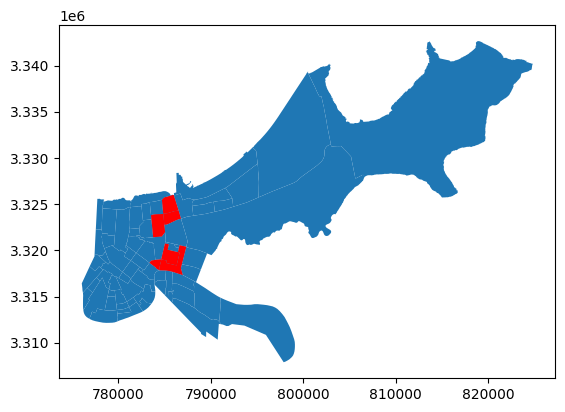

In [11]:
ax = neighborhoodDf.plot()
neighborhoodDf[captureHoodsMask].plot(ax=ax, color='red')

In [12]:
bounds = [int(b) for b in neighborhoodDf[captureHoodsMask].total_bounds]

In [13]:
xPixels = (bounds[2] - bounds[0]) / resolution
yPixels = (bounds[3] - bounds[1]) / resolution
lp(f"Resolution will be {xPixels} x {yPixels}  Runtime based on {xPixels*yPixels}")

[2025-03-25 21:23:24.688821] Resolution will be 3.986 x 8.678  Runtime based on 34.59050800000001


In [14]:
boxes = [shapely.box(x,y,x+resolution,y+resolution) for x, y in product(range(bounds[0], bounds[2], resolution), range(bounds[1], bounds[3], resolution))]
boxesDf = gpd.GeoDataFrame(geometry=boxes).set_crs(neighborhoodDf.crs)
boxesDf = boxesDf[boxesDf.intersects(neighborhoodDf[captureHoodsMask].union_all())].copy()
boxesDf['AltitudeTotal'] = np.nan
boxesDf['WaterTotal'] = np.nan
boxesDf['Total'] = np.nan
boxesDf['RunTime'] = datetime.now()-datetime.now()


<Axes: >

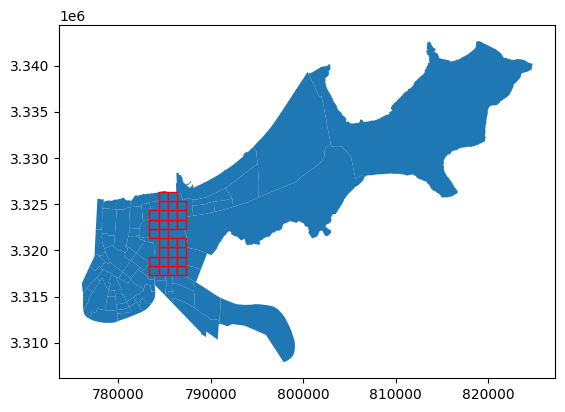

In [15]:
ax = neighborhoodDf.plot()
boxesDf.plot(edgecolor='red', color=None, ax=ax)

In [16]:
tileIndex = gpd.read_file(f"{dataPath}USGS_LA_2021GNO_1_C22_TileIndex{os.sep}USGS_LA_2021GNO_1_C22_TileIndex.shp").to_crs(neighborhoodDf.crs)
tileIndex.index = tileIndex['Name'].map(lambda f: f"{fullDataPath}laz{os.sep}USGS_LPC_LA_2021GreaterNewOrleans_C22_{f}.laz")
tileIndexBroadcast = sc.broadcast(tileIndex)
tileIndexBroadcast.value.head()

,Name,Comment,PRJ_ID,WU_ID,WU_Name,geometry
Name,,,,,,
/home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0809n3329.laz,w0809n3329,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((810000 3329000, 809000 3329000, 8090..."
/home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0755n3296.laz,w0755n3296,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((756000 3296000, 755000 3296000, 7550..."
/home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0673n3303.laz,w0673n3303,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((674000 3303000, 673500 3303000, 6735..."
/home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0704n3295.laz,w0704n3295,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((705000 3295000, 704000 3295000, 7040..."
/home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0748n3320.laz,w0748n3320,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((749000 3320000, 748000 3320000, 7480..."


In [17]:
wgsToUTM = pyproj.transformer.Transformer.from_crs(crs_from=pyproj.CRS.from_string('WGS84'), crs_to=neighborhoodDf.crs)
meridianReg = re.compile(r'PARAMETER\["central_meridian",\-([0-9]{2})\]')


def processLas(inputTup):
    startTime = datetime.now()
    
    BoxIdx = inputTup[0]
    boxBounds = inputTup[1:]
    
    lp(f"Processing for box[{BoxIdx}] {boxBounds}")

    altTotal = 0
    waterTotal = 0
    pointTotal = 0
    for idx, row in tileIndexBroadcast.value.iterrows():
        if not row['geometry'].intersects(shapely.box(*boxBounds)):
            #no intersection scip
            continue

        try:        
            las = laspy.read(idx)
        except FileNotFoundError:
            lp(f"path {idx} does not exist skipping" )
            continue
        
        
        central_meridian = int(meridianReg.findall(las.header.vlrs[0].string)[0]) * -1
    
        
        X = las.X
        Y = las.Y
        Z = las.Z
        cls = las.classification
    
        groundMask = np.isin(cls, [2,9])
        inBoundsMaskX = np.logical_and(X >= (boxBounds[0]*1000), (X <= (boxBounds[2]*1000)))
        inBoundsMaskY = np.logical_and(Y >= (boxBounds[1]*1000), (Y <= (boxBounds[3]*1000)))
        goodPointMask = np.logical_and(groundMask,inBoundsMaskX,inBoundsMaskY)
        
        x = X[goodPointMask]/1000.0 #- bounds[0]
        y = (Y[goodPointMask]/1000.0 + wgsToUTM.transform(30,central_meridian)[1]) #- bounds[1]
 
        altTotal += int(Z[goodPointMask].sum())
        waterTotal += np.count_nonzero(cls[goodPointMask] == 9)
        pointTotal += np.count_nonzero(goodPointMask)

    return (BoxIdx,altTotal, waterTotal, pointTotal, datetime.now() - startTime)


In [18]:
#Just for sanity
testIdx = 7
processLas(list(boxesDf.bounds.itertuples())[testIdx])

[2025-03-25 21:23:25.342478] Processing for box[11] (784367.0, 3319320.0, 785367.0, 3320320.0)


(11,
 -4431858903,
 69,
 4887323,
 datetime.timedelta(seconds=9, microseconds=597916))

In [19]:
boxesRdd = sc.parallelize(boxesDf.bounds.itertuples(), 300)

In [20]:
boxesProcessedRdd = boxesRdd.map(processLas)

In [21]:
lp(f"{boxesDf.shape[0]} boxes total")

[2025-03-25 21:23:35.122017] 29 boxes total


In [22]:
output = boxesProcessedRdd.collect()

In [23]:
boxesDf.columns

Index(['geometry', 'AltitudeTotal', 'WaterTotal', 'Total', 'RunTime'], dtype='object')

In [24]:
output[0]

(0,
 4276135290,
 1276,
 2023124,
 datetime.timedelta(seconds=21, microseconds=275743))

In [25]:
for out in output:
    boxesDf.loc[out[0], 'AltitudeTotal'] = out[1]
    boxesDf.loc[out[0], 'WaterTotal'] = out[2]
    boxesDf.loc[out[0], 'Total'] = out[3]
    boxesDf.loc[out[0], 'RunTime'] = out[4]

In [26]:
lp(f"{boxesDf['RunTime'].mean()} avg runtime\t\ttotal:  {boxesDf['RunTime'].sum()}")

[2025-03-25 21:26:38.354076] 0 days 00:00:21.165284 avg runtime		total:  0 days 00:10:13.793251


In [27]:
boxesDf.head()

,geometry,AltitudeTotal,WaterTotal,Total,RunTime
0,"POLYGON ((784367 3317320, 784367 3318320, 7833...",4.276135e+09,1276.0,2023124.0,0 days 00:00:21.275743
1,"POLYGON ((784367 3318320, 784367 3319320, 7833...",1.805163e+09,553.0,3194735.0,0 days 00:00:28.491802
4,"POLYGON ((784367 3321320, 784367 3322320, 7833...",-2.198632e+09,19.0,4423814.0,0 days 00:00:29.258611
5,"POLYGON ((784367 3322320, 784367 3323320, 7833...",-2.392842e+09,0.0,4336845.0,0 days 00:00:24.153111
6,"POLYGON ((784367 3323320, 784367 3324320, 7833...",-7.785911e+09,0.0,4549287.0,0 days 00:00:29.000682


In [28]:
boxesDf.to_pickle(outputFileName)

In [29]:
with open(f"{outPath}FinishTime_{resolution}m.txt", 'w') as f:
    f.write(f"Finished shape {boxesDf.shape}  stop time {datetime.now()}")

<Axes: >

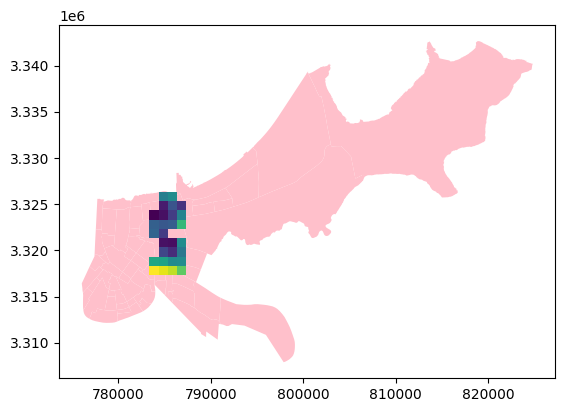

In [34]:
boxesDf['AltCalc'] = boxesDf['AltitudeTotal'] / boxesDf['Total']
boxesDf.loc[pd.isna(boxesDf['AltCalc']),'AltCalc'] = 0
ax = neighborhoodDf.plot(color='pink')
boxesDf.plot(column='AltCalc',ax=ax)

In [31]:
lp("Done!")

[2025-03-25 21:26:38.496134] Done!
